In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [393]:
# House 1 data Analysis
house1 = pd.read_csv('../data/64613.csv')
# print(house1.columns)
house1.drop(columns='Unnamed: 0', inplace=True)
house1.drop_duplicates(inplace=True)
house1['reading_datetime'] = pd.to_datetime(house1['reading_datetime'])
house1.loc[house1['circuit_id'] == 58077,'monitors'] = 'load_air_conditioner1'
house1.loc[house1.circuit_id == 70173, 'monitors'] = 'ppt1'
house1.loc[house1.circuit_id == 70174, 'monitors'] = 'ppt2'
house1.loc[house1.circuit_id == 70175, 'monitors'] = 'ppt3'
house1.loc[house1.circuit_id == 58086, 'monitors'] = 'ppt4'
house1.set_index(keys=['reading_datetime', 'monitors'], inplace=True, drop=True)
house1.sort_index(inplace=True)
house1.drop(columns=['site_id', 'circuit_id', 'energy_pos', 'energy_neg'], inplace=True)

house1 = house1.stack().unstack(level=1)
uncontrollable = ['load_air_conditioner', 'load_air_conditioner1', 'load_lighting', 'load_stove', 'ppt1', 'ppt2', 'ppt3', 'ppt4']
controllable = ['load_hot_water']
house1['uncontrollable'] = house1[uncontrollable].sum(axis=1)
house1['controllable'] = house1[controllable].sum(axis=1)
house1['excessPV'] = (house1.pv_site_net - house1.uncontrollable).clip(lower=0)
house1 = house1.assign(consumption = house1.ac_load_net + house1.pv_site_net)
house1 = house1.droplevel(level=1)

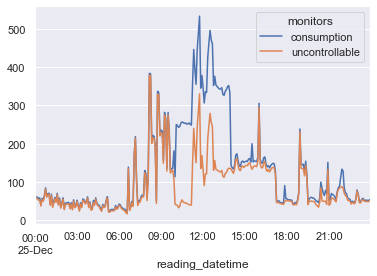

In [394]:
# house1
resampled = house1.resample('5min').sum()
summer = resampled['2019-12'].append(resampled['2019-01':'2019-02'])
autumn = resampled['2019-03':'2019-05']
winter = resampled['2019-06':'2019-08']
spring = resampled['2019-09':'2019-11']

summer['2019-12-25'].plot(y=['consumption', 'uncontrollable'])

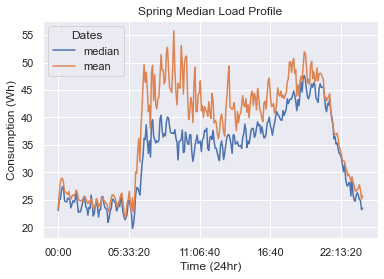

In [383]:
spring = spring.assign(Dates = spring.index)
spring = spring.assign(Time = spring.index.time)
spring_pivot = spring.pivot(index='Time', columns='Dates', values='uncontrollable')
spring_pivot['median'] = spring_pivot.median(axis=1)
spring_pivot['mean'] = spring_pivot.mean(axis=1)
ax = spring_pivot.plot(y=['median', 'mean'])
ax.set_title('Spring Median Load Profile')
ax.set_ylabel('Consumption (Wh)')
ax.set_xlabel('Time (24hr)')
plt.show()

C:\Users\camer\anaconda3\envs\QuickPandas\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\camer\anaconda3\envs\QuickPandas\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


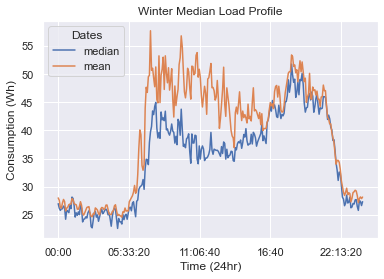

In [384]:
winter.loc[:,'Dates'] = winter.index
winter.loc[:,'Time'] = winter.index.time
winter_pivot = winter.pivot(index='Time', columns='Dates', values='uncontrollable')
winter_pivot.loc[:,'median'] = winter_pivot.median(axis=1)
winter_pivot.loc[:,'mean'] = winter_pivot.mean(axis=1)
ax = winter_pivot.plot(y=['median', 'mean'])
ax.set_title('Winter Median Load Profile')
ax.set_ylabel('Consumption (Wh)')
ax.set_xlabel('Time (24hr)')
plt.show()

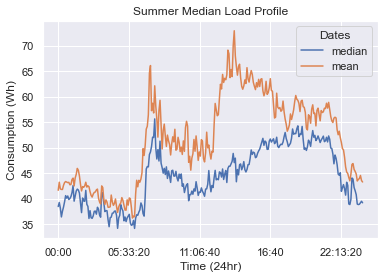

In [385]:
summer['Dates'] = summer.index
summer['Time'] = summer.index.time
summer_pivot = summer.pivot(index='Time', columns='Dates', values='uncontrollable')
summer_pivot['median'] = summer_pivot.median(axis=1)
summer_pivot['mean'] = summer_pivot.mean(axis=1)
ax = summer_pivot.plot(y=['median', 'mean'])
ax.set_title('Summer Median Load Profile')
ax.set_ylabel('Consumption (Wh)')
ax.set_xlabel('Time (24hr)')
plt.show()

C:\Users\camer\anaconda3\envs\QuickPandas\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\camer\anaconda3\envs\QuickPandas\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


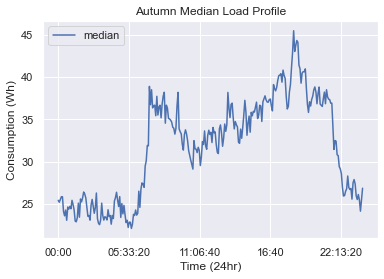

In [395]:
autumn['Dates'] = autumn.index
autumn['Time'] = autumn.index.time
autumn_pivot = autumn.pivot(index='Time', columns='Dates', values='uncontrollable')
autumn_pivot['median']=autumn_pivot.median(axis=1)
autumn_pivot['mean']=autumn_pivot.mean(axis=1)
ax =autumn_pivot.plot(y='median')
ax.set_title('Autumn Median Load Profile')
ax.set_ylabel('Consumption (Wh)')
ax.set_xlabel('Time (24hr)')
plt.show()

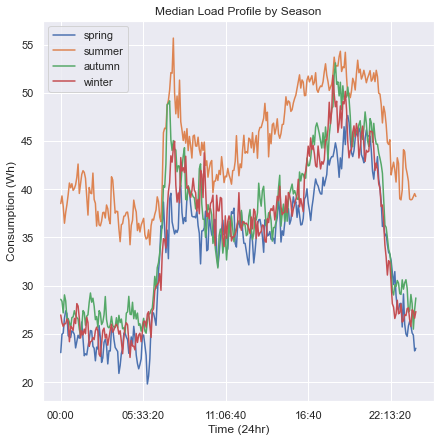

In [387]:
fig, ax = plt.subplots(figsize=(7,7))
spring_pivot.plot(y='median', ax=ax, label='spring')
summer_pivot.plot(y='median', ax=ax, label='summer')
autumn_pivot.plot(y='median', ax=ax, label='autumn')
winter_pivot.plot(y='median', ax=ax, label='winter')
ax.set_title('Median Load Profile by Season')
ax.set_ylabel('Consumption (Wh)')
ax.set_xlabel('Time (24hr)')
plt.show()

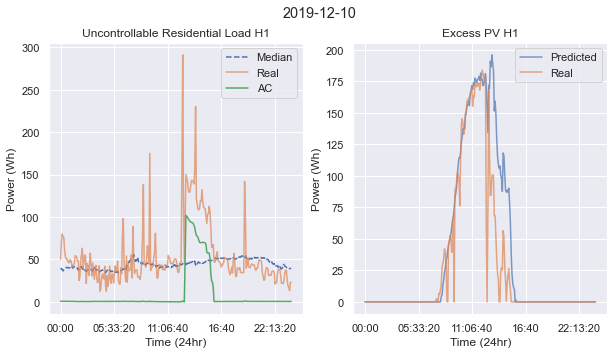

In [444]:

day = summer['2019-12-10']
day = day.set_index(day.index.time)
day['predictedExcessPV'] = (day['pv_site_net'] - summer_pivot['median']).clip(lower=0)
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
summer_pivot.plot(y='median', style='--', ax=ax[0], label='Median')
day.plot(y='uncontrollable', ax=ax[0], alpha=0.7, label='Real')
day.plot(y='load_air_conditioner', ax=ax[0], label='AC')
day.plot(y=['predictedExcessPV', 'excessPV'], ax=ax[1], alpha=0.7, label=['Predicted', 'Real'])
ax[0].set_ylabel('Power (Wh)')
ax[0].set_xlabel('Time (24hr)')
ax[0].set_title('Uncontrollable Residential Load H1')
ax[1].set_ylabel('Power (Wh)')
ax[1].set_xlabel('Time (24hr)')
ax[1].set_title('Excess PV H1')
fig.suptitle('2019-12-10')
plt.show()



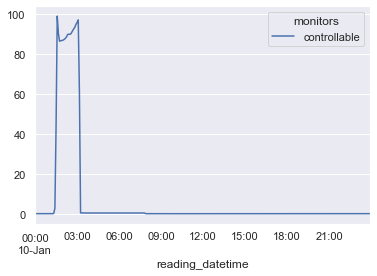

In [458]:
house1.loc[((house1['controllable']>0) & (house1['excessPV']> 0)),'CLPV'] = ((house1['controllable']>0) & (house1['excessPV']> 0))
house1['2019-01-10'].plot(y=['controllable','CLPV'])